In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
# from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
# from tensorflow.keras.models import Model
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# import tqdm

1. Load Fashion MNIST Data

In [2]:
train_csv = pd.read_csv("./datasets/fashion/fashion-mnist_train.csv")
test_csv = pd.read_csv("./datasets/fashion/fashion-mnist_test.csv")
batch_size = 100

# separate training into training and validation
validation_split = .2
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
train_size = len(train_csv)
indices = list(range(train_size))
split = int(np.floor(validation_split * train_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

class FashionData(Dataset):
    '''
    User-define class to build a dataset using Pytorch class Dataset,
    with 2 methods: get_item() and len():
        get_item() return the images and labels
        len() returns the number of items in a dataset.
    '''
    def __init__(self, data, transform=None):
        '''Initialize variables'''
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        label = []
        image = []
        for i in self.fashion_MNIST:
            label.append(i[0])#first col is the label
            image.append(i[1:]/255.) # normalize
        
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1,28,28,1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    def __len__(self):
        return len(self.images)
    
#Load data into Tensor with transformation on the image (pixel --> range from 0 to 1)
# transforms.ToTensor(): Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
#       to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
train_data = FashionData(train_csv, transform=transforms.Compose([transforms.ToTensor()])) 
# valid_data = FashionData(valid_csv, transform=transforms.Compose([transforms.ToTensor()])) 
test_data = FashionData(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

# wrapup into dataloader
train_loader = DataLoader(train_data, batch_size=batch_size,sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=False)


2.1 Basic Autoencoders using feedfoward nn -- model setup and train

In [3]:
# latent_dim = 64

class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # self.latent_dim = latent_dim
        # encoder (1 layer)
        self.encoder = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(in_features=kwargs["input_shape"],out_features=kwargs["latent_shape"]),
            nn.ReLU())
        # decoder (1 layer)
        self.decoder = nn.Sequential(
            nn.Linear(in_features=kwargs["latent_shape"],out_features=kwargs["input_shape"]),
            nn.Sigmoid())
            # torch.reshape((28,28)))

    def forward(self, input_features):
        encoded = self.encoder(input_features)
        decoded = self.decoder(encoded)
        return decoded
    
# load model to the specified device, either gpu or cpu
autoencoder = Autoencoder(input_shape=784,latent_shape=64).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train model
def train_AE(num_epochs,model,optimizer,criterion,train_loader,valid_loader):
    # for epoch in tqdm(range(epochs)):
    for epoch in range(num_epochs):
        loss_tr = 0
        loss_val = 0
        # training loop
        for batch_features, _ in train_loader:
            # load it to active device
            batch_features = batch_features.view(-1, 784).to(device)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            # compute reconstructions
            outputs = model(batch_features)
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            # compute accumulated gradients
            train_loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # add the mini-batch training loss to epoch loss
            loss_tr += train_loss.item()
        # compute the epoch training loss
        loss_tr = loss_tr / len(train_loader)

        # valid loop
        with torch.no_grad():
            model.eval()
            for batch_features, _ in valid_loader: 
                batch_features = batch_features.view(-1, 784).to(device)
                reconstructed = model(batch_features)
                valid_loss = criterion(reconstructed, batch_features)
                loss_val += valid_loss.item()
            loss_val = loss_val / len(train_loader)

        # display the epoch loss
        print("epoch : {}/{},  traing loss = {:.6f}, valid loss = {:.6f}".format(epoch + 1, num_epochs, loss_tr, loss_val))

train_AE(num_epochs=10,model=autoencoder,optimizer=optimizer,criterion=criterion,train_loader=train_loader, valid_loader=valid_loader)

epoch : 1/10,  traing loss = 0.044011, valid loss = 0.006568
epoch : 2/10,  traing loss = 0.021527, valid loss = 0.004559
epoch : 3/10,  traing loss = 0.016552, valid loss = 0.003777
epoch : 4/10,  traing loss = 0.014434, valid loss = 0.003432
epoch : 5/10,  traing loss = 0.013392, valid loss = 0.003245
epoch : 6/10,  traing loss = 0.012818, valid loss = 0.003138
epoch : 7/10,  traing loss = 0.012447, valid loss = 0.003063
epoch : 8/10,  traing loss = 0.012181, valid loss = 0.003025
epoch : 9/10,  traing loss = 0.012004, valid loss = 0.002969
epoch : 10/10,  traing loss = 0.011862, valid loss = 0.002952


In [ ]:
# Summary of the model
print(autoencoder)

2.2 model testing

In [4]:
def test_AE(model,test_loader):
    loss = 0
    reconstructed_imgs = []
    with torch.no_grad():
        model.eval()
        for batch_features,_ in test_loader:
            batch_features = batch_features.view(-1, 784).to(device)
            reconstructed = model(batch_features)
            test_loss = criterion(reconstructed, batch_features)
            loss += test_loss.item()
            reconstructed_imgs.append(reconstructed.numpy())
        loss = loss / len(test_loader)
        print("Testing loss = {:.6f}".format(loss))
    return reconstructed_imgs

reconstructed_imgs_te = test_AE(model=autoencoder,test_loader=test_loader)            

Testing loss = 0.011870


2.3. test reconstructed image display

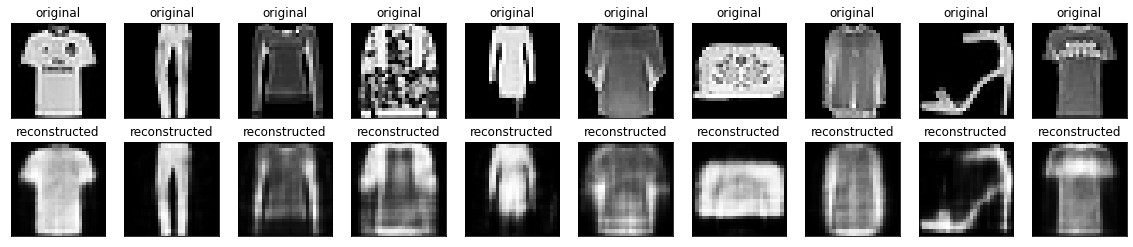

In [5]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_data.images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_imgs_te[0][i].reshape((28,28)))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

3.1 Image denoising

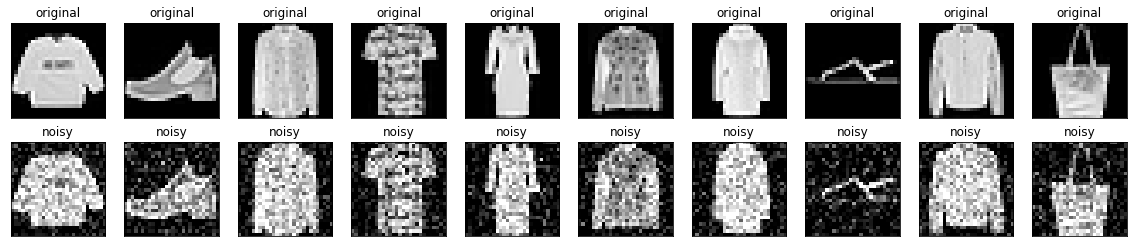

In [6]:
# add noise
def add_noise(image, noise_factor):
    image_noisy = torch.tensor(image) + noise_factor * torch.randn(image.shape)
    image_noisy = torch.clamp(image_noisy,min=0., max=1.)
    return image_noisy

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(train_data.images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(add_noise(train_data.images[i], 0.2))
  plt.title("noisy")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
# latent_dim = 64

class Autoencoder_Denoise(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # self.latent_dim = latent_dim
        # encoder (1 layer); Input=28*28
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8)
            )
        # decoder (1 layer)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
            )

    def forward(self, input_features):
        encoded = self.encoder(input_features)
        decoded = self.decoder(encoded)
        return decoded
    
# load model to the specified device, either gpu or cpu
autoencoder_denoise = Autoencoder_Denoise().to(device)
optimizer_denoise = torch.optim.Adam(autoencoder_denoise.parameters(), lr=1e-3)
criterion_denoise = nn.MSELoss()

# Train model
def train_AE_denoise(num_epochs,model,optimizer,criterion,train_loader,valid_loader,noise_factor):
    # for epoch in tqdm(range(epochs)):
    for epoch in range(num_epochs):
        loss_tr = 0
        loss_val = 0
        # training loop
        for batch_features, _ in train_loader:
            # print("######",batch_features.shape)
            # load it to active device
            batch_features = batch_features.to(device)
            batch_features_noisy = add_noise(batch_features, noise_factor=noise_factor).to(device)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            # compute reconstructions
            outputs = model(batch_features_noisy)
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            # compute accumulated gradients
            train_loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # add the mini-batch training loss to epoch loss
            loss_tr += train_loss.item()
        # compute the epoch training loss
        loss_tr = loss_tr / len(train_loader)

        # valid loop
        with torch.no_grad():
            model.eval()
            for batch_features, _ in valid_loader: 
                batch_features = batch_features.to(device)
                batch_features_noisy = add_noise(batch_features, noise_factor=noise_factor).to(device)
                denoised = model(batch_features_noisy)
                valid_loss = criterion(denoised, batch_features)
                loss_val += valid_loss.item()
            loss_val = loss_val / len(train_loader)

        # display the epoch loss
        print("epoch : {}/{},  traing loss = {:.6f}, valid loss = {:.6f}".format(epoch + 1, num_epochs, loss_tr, loss_val))

noise_factor = 0.2
train_AE_denoise(num_epochs=10,model=autoencoder_denoise,optimizer=optimizer_denoise,\
    criterion=criterion_denoise,train_loader=train_loader, valid_loader=valid_loader, noise_factor=noise_factor)

/var/folders/_8/wgwrcgx12rl79q25snrc8l140000gn/T/ipykernel_2107/2489251226.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_noisy = torch.tensor(image) + noise_factor * torch.randn(image.shape)


epoch : 1/10,  traing loss = 0.023169, valid loss = 0.002519
epoch : 2/10,  traing loss = 0.009864, valid loss = 0.002436
epoch : 3/10,  traing loss = 0.009748, valid loss = 0.002424
epoch : 4/10,  traing loss = 0.009713, valid loss = 0.002418
epoch : 5/10,  traing loss = 0.009688, valid loss = 0.002412
epoch : 6/10,  traing loss = 0.009675, valid loss = 0.002419
epoch : 7/10,  traing loss = 0.009666, valid loss = 0.002409
epoch : 8/10,  traing loss = 0.009663, valid loss = 0.002420
epoch : 9/10,  traing loss = 0.009664, valid loss = 0.002425
epoch : 10/10,  traing loss = 0.009652, valid loss = 0.002408


In [10]:
# Summary of the model
print(autoencoder_denoise)

Autoencoder_Denoise(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


3.2 model testing

In [12]:
def test_AE_denoise(model,test_loader,noise_factor):
    loss = 0
    denoised_imgs = []
    noisy_imgs = []
    with torch.no_grad():
        model.eval()
        for batch_features,_ in test_loader:
            batch_features = batch_features.to(device)
            batch_features_noisy = add_noise(batch_features, noise_factor=noise_factor).to(device)
            denoised = model(batch_features_noisy)
            test_loss = criterion(denoised, batch_features)
            loss += test_loss.item()
            denoised_imgs.append(denoised.numpy())
            noisy_imgs.append(batch_features_noisy.numpy())
        loss = loss / len(test_loader)
        print("Testing loss = {:.6f}".format(loss))
    return noisy_imgs,denoised_imgs

noisy_imgs_te,denoised_imgs_te = test_AE_denoise(model=autoencoder_denoise,test_loader=test_loader,noise_factor=noise_factor)    

/var/folders/_8/wgwrcgx12rl79q25snrc8l140000gn/T/ipykernel_2107/2489251226.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_noisy = torch.tensor(image) + noise_factor * torch.randn(image.shape)


Testing loss = 0.009630


3.3. test denoised image display

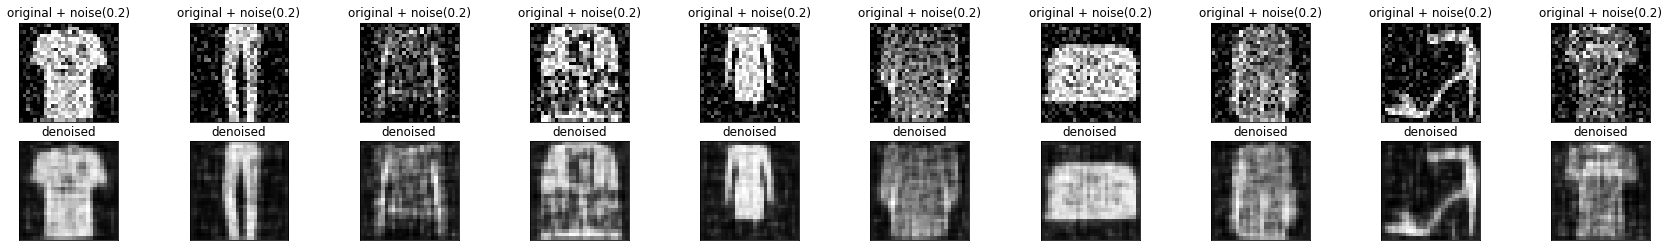

In [16]:
n = 10
plt.figure(figsize=(30, 4))
for i in range(n):
  # display original + noise
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(noisy_imgs_te[0][i].reshape((28,28)))
  plt.title("original + noise(0.2)")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display denoised
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(denoised_imgs_te[0][i].reshape((28,28)))
  plt.title("denoised")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()